<a href="https://colab.research.google.com/github/Ruhylll/hyfinbootcamp/blob/main/Samsung_stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

level1. 각자의 종목 캔들차트에 5일 20일 이동평균선을 그려보세요.(개인과제)

In [ ]:
!pip install mplfinance
import requests
import pandas as pd
from datetime import datetime, timedelta
import mplfinance as mpf
import numpy as np


In [ ]:
# 오늘 날짜와 한 달 전 (예시: 2025-09-26 기준)
today = datetime.strptime("2025-09-26", "%Y-%m-%d")
three_month_ago = today - timedelta(days=120)

all_data = [] ##구간으로 가져오는 함수가 작동하지 않아서 일별 데이터를 긁어와 한 리스트에 저장하기 위해

In [ ]:
# 1. 날짜별로 반복 요청
for i in range(121): #3달간의 날짜 for문으로 반복실행
    day = three_month_ago + timedelta(days=i)
    trdDd = day.strftime("%Y%m%d") #가져오는 날짜

    params = {
        "bld": "dbms/MDC/STAT/standard/MDCSTAT01501",
        "mktId": "STK",
        "trdDd": trdDd, #strDd, endDd가 작동하지 않아 trdDd로 실
        "share": "1",
        "money": "1",
        "csvxls_isNo": "false"
    }
    res = requests.get(url, params=params, headers=headers) # http get request

    try:
        data = res.json().get("OutBlock_1", []) #res.text -> res.json 파싱
    except Exception: #예외처리로 exception  발생시 그냥 코드 실행
        continue

    samsung = [d for d in data if d["ISU_SRT_CD"] == "005930"] #삼성전자인 것만 리스트로 추출
    if samsung:
        row = samsung[0]

        # 휴장일 데이터('-') 처리
        if row["TDD_CLSPRC"] == "-": #주말에는 데이터가 없으므로, 오류가 난다. exeption 처리이다.
            continue

        all_data.append({
            "Date": day,
            "Close": float(row["TDD_CLSPRC"].replace(",", "")),
            "Open": float(row["TDD_OPNPRC"].replace(",", "")),
            "High": float(row["TDD_HGPRC"].replace(",", "")),
            "Low": float(row["TDD_LWPRC"].replace(",", "")),
            "Volume": float(row["ACC_TRDVOL"].replace(",", ""))
        })


In [ ]:
# 2. DataFrame 변환
df = pd.DataFrame(all_data) #데이터프레임으로 변경
df = df.set_index("Date").sort_index() #날짜에 따라 정렬

In [ ]:
# 3. 이동평균선 계산
df["MA5"] = df["Close"].rolling(window=5).mean() #.rolling(window=5) 직전 5일간의 값들을 묶어서 계산 종가 부분을
df["MA20"] = df["Close"].rolling(window=20).mean() # ~~~
print(df.tail()) # ma5 와 ma20 확인

              Close     Open     High      Low      Volume      MA5     MA20
Date                                                                        
2025-09-24  85400.0  84200.0  85500.0  83700.0  18300997.0  84740.0  79670.0
2025-09-25  86100.0  84400.0  86200.0  84100.0  19665151.0  85260.0  80305.0
2025-09-25  86100.0  84400.0  86200.0  84100.0  19665151.0  85540.0  80940.0
2025-09-26  83300.0  85000.0  85300.0  82400.0  24071193.0  85260.0  81335.0
2025-09-26  83300.0  85000.0  85300.0  82400.0  24071193.0  84840.0  81730.0


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


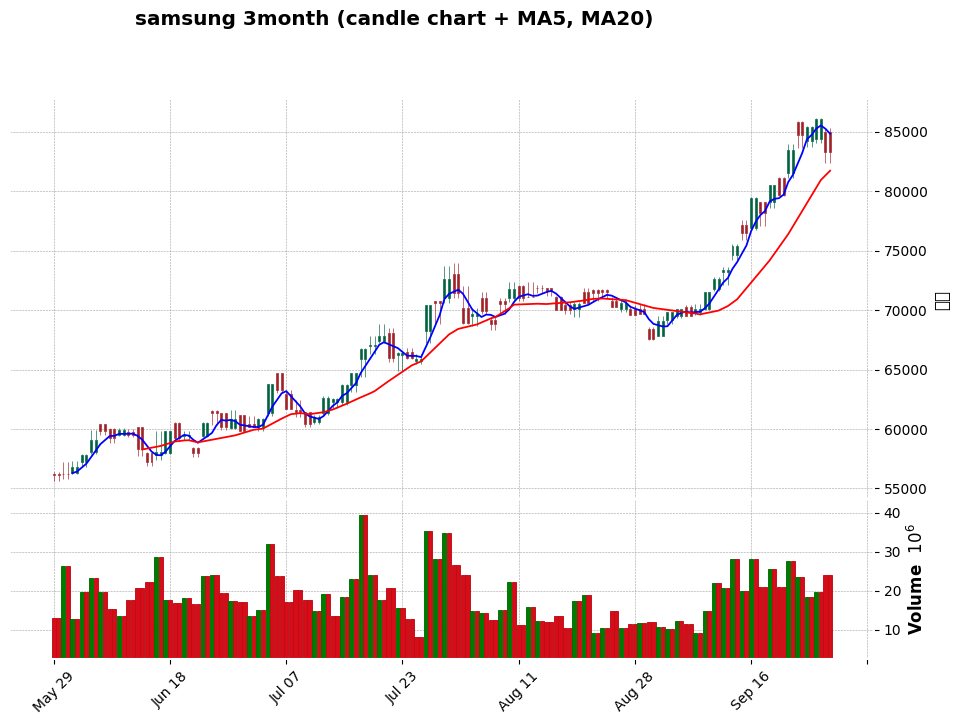

In [ ]:
# 4. 캔들차트 + 이동평균선
apds = [
    mpf.make_addplot(df["MA5"], color="blue"), #캔들차트 위에 보조선 mpf.make_addplot
    mpf.make_addplot(df["MA20"], color="red")
]

mpf.plot(
    df,
    type="candle",
    style="charles",
    title="samsung 3month (candle chart + MA5, MA20)",
    ylabel="주가",
    volume=True,
    addplot=apds,
    figsize=(12, 8)
)

level2. 각자의 팀이 선택한 보조지표는 어떤 의미이며, 어떻게 계산되는 지표인가요? 또한 해당 지표를 코드로 시각화하여 각자 종목의 현재 상태를 해석해보세요 왜 그런 결과가 나왔을까요?(팀 과제)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.dates import DateFormatter

In [ ]:
df = pd.DataFrame(all_data)
df['Date'] = pd.to_datetime(df['Date'])

14일 기준 스토캐스틱 Fast %K 계산

In [ ]:
df['Lowest_N_Days'] = df['Low'].rolling(window=14).min()
df['Highest_N_Days'] = df['High'].rolling(window=14).max()
df['%K'] = (df['Close'] - df['Lowest_N_Days']) / (df['Highest_N_Days'] - df['Lowest_N_Days']) * 100

In [ ]:
df['%D'] = df['%K'].rolling(window=3).mean()

Slow

In [ ]:
df['Slow_%K'] = df['%K'].rolling(window=3).mean()
df['Slow_%D'] = df['Slow_%K'].rolling(window=3).mean()

figure

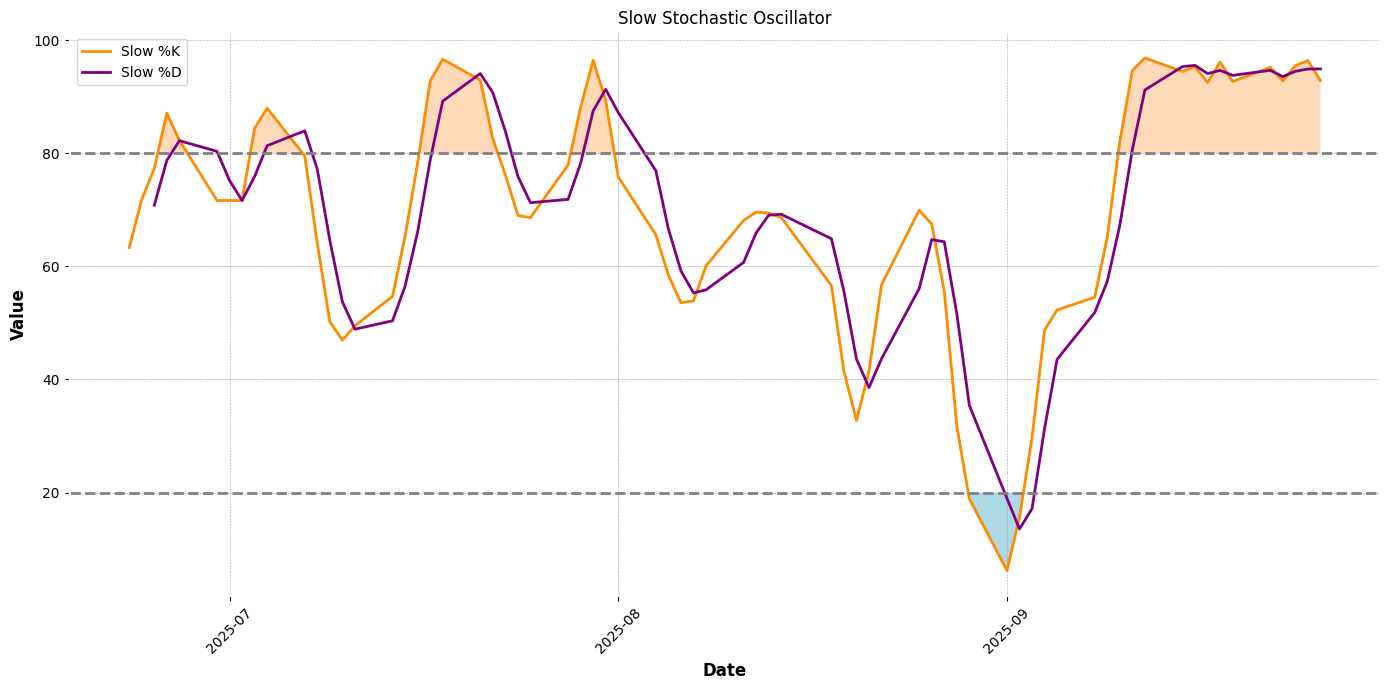

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df['Date'], df['Slow_%K'], color='darkorange', label='Slow %K')
ax.plot(df['Date'], df['Slow_%D'], color='purple', label='Slow %D')

ax.axhline(20, color='grey', linestyle='--')
ax.axhline(80, color='grey', linestyle='--')

ax.fill_between(df['Date'], df['Slow_%K'], 20, where=(df['Slow_%K'] <= 20), facecolor='lightblue', interpolate=True)
ax.fill_between(df['Date'], df['Slow_%K'], 80, where=(df['Slow_%K'] >= 80), facecolor='peachpuff', interpolate=True)

ax.set_title("Slow Stochastic Oscillator")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

plt.show()

%k와 %d plot 생성

In [ ]:
ax.plot(df['Date'], df['Slow_%K'], color='darkorange', label='Slow %K')
ax.plot(df['Date'], df['Slow_%D'], color='purple', label='Slow %D')

기준선 (20, 80) 추가

In [ ]:
ax.axhline(20, color='grey', linestyle='--')
ax.axhline(80, color='grey', linestyle='--')

조건부 영역 채우기

In [ ]:
ax.fill_between(df['Date'], df['Slow_%K'], 20, where=(df['Slow_%K'] <= 20), facecolor='lightblue', interpolate=True)

ax.fill_between(df['Date'], df['Slow_%K'], 80, where=(df['Slow_%K'] >= 80), facecolor='peachpuff', interpolate=True)

In [ ]:
ax.set_title("Slow Stochastic Oscillator")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>